<a href="https://colab.research.google.com/github/ErangaOttachchige/Final-Year-Research-Project/blob/main/analysis_table_(species_labels_%2B_empty_%2B_subsets)_Upppppdated_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
print("CUDA:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

CUDA: False
GPU: None


In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
import os
DRIVE_CCT = "/content/drive/MyDrive/datasets/cct20"
os.makedirs(f"{DRIVE_CCT}/raw", exist_ok=True)
os.makedirs(f"{DRIVE_CCT}/processed", exist_ok=True)
print("Created:", DRIVE_CCT)
print("Contents:", os.listdir("/content/drive/MyDrive/datasets"))


Created: /content/drive/MyDrive/datasets/cct20
Contents: ['cct20']


In [4]:
!wget -O /content/drive/MyDrive/datasets/cct20/raw/eccv_18_all_images_sm.tar.gz \
  https://storage.googleapis.com/public-datasets-lila/caltechcameratraps/eccv_18_all_images_sm.tar.gz

!wget -O /content/drive/MyDrive/datasets/cct20/raw/eccv_18_annotations.tar.gz \
  https://storage.googleapis.com/public-datasets-lila/caltechcameratraps/eccv_18_annotations.tar.gz


--2026-02-03 08:16:25--  https://storage.googleapis.com/public-datasets-lila/caltechcameratraps/eccv_18_all_images_sm.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.98.207, 142.251.107.207, 74.125.196.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.98.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6492615601 (6.0G) [application/x-tar]
Saving to: ‘/content/drive/MyDrive/datasets/cct20/raw/eccv_18_all_images_sm.tar.gz’

/content/drive/MyDr 100%[===================>]   6.05G  47.7MB/s    in 2m 8s   

2026-02-03 08:18:33 (48.4 MB/s) - ‘/content/drive/MyDrive/datasets/cct20/raw/eccv_18_all_images_sm.tar.gz’ saved [6492615601/6492615601]

--2026-02-03 08:18:34--  https://storage.googleapis.com/public-datasets-lila/caltechcameratraps/eccv_18_annotations.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.134.207, 74.125.139.207, 173.194.210.207, ...
Connecting to storage.googleapi

In [5]:
!tar -xzf /content/drive/MyDrive/datasets/cct20/raw/eccv_18_all_images_sm.tar.gz \
  -C /content/drive/MyDrive/datasets/cct20/

!tar -xzf /content/drive/MyDrive/datasets/cct20/raw/eccv_18_annotations.tar.gz \
  -C /content/drive/MyDrive/datasets/cct20/

In [6]:
import glob, os
print("Top folders:", os.listdir(DRIVE_CCT))
print("JPG count:", len(glob.glob(f"{DRIVE_CCT}/**/*.jpg", recursive=True)))


Top folders: ['raw', 'processed', 'eccv_18_all_images_sm', 'eccv_18_annotation_files']
JPG count: 57864


In [7]:
!pip -q install pandas numpy matplotlib scikit-learn pillow tqdm


In [8]:
import json
from pathlib import Path
import pandas as pd

DRIVE_CCT = Path("/content/drive/MyDrive/datasets/cct20")
IMG_ROOT = DRIVE_CCT / "eccv_18_all_images_sm"
ANN_ROOT = DRIVE_CCT / "eccv_18_annotation_files"
OUT_CSV  = DRIVE_CCT / "processed" / "cct20_species_annotations.csv"

def is_coco_like(d):
    return isinstance(d, dict) and all(k in d for k in ["images","annotations","categories"])

def resolve_image_path(file_name: str):
    p = IMG_ROOT / file_name
    if p.exists():
        return str(p)
    # fallback: search by basename (slower but reliable)
    hits = list(IMG_ROOT.rglob(Path(file_name).name))
    return str(hits[0]) if hits else None

rows = []
used = 0

for jp in sorted(ANN_ROOT.rglob("*.json")):
    with open(jp, "r", encoding="utf-8") as f:
        data = json.load(f)
    if not is_coco_like(data):
        continue

    cat_id_to_name = {c["id"]: str(c.get("name","")) for c in data["categories"]}
    cat_id_to_name_lower = {k:v.lower() for k,v in cat_id_to_name.items()}

    imgid_to_file = {}
    for im in data["images"]:
        fn = im.get("file_name") or im.get("filename")
        if fn is not None:
            imgid_to_file[im["id"]] = fn

    subset = jp.stem
    kept = 0

    for a in data["annotations"]:
        img_id = a["image_id"]
        cat_id = a["category_id"]

        fn = imgid_to_file.get(img_id)
        if not fn:
            continue

        path = resolve_image_path(fn)
        if not path:
            continue

        name = cat_id_to_name.get(cat_id, "unknown")
        is_empty = int(("empty" in cat_id_to_name_lower.get(cat_id,"")) or ("blank" in cat_id_to_name_lower.get(cat_id,"")))

        rows.append({
            "subset": subset,
            "image_id": img_id,
            "file_name": fn,
            "path": path,
            "category_id": cat_id,
            "category_name": name,
            "is_empty": is_empty,
            "bbox": tuple(a["bbox"]) if isinstance(a.get("bbox", None), list) else a.get("bbox", None),

        })
        kept += 1

    if kept > 0:
        used += 1
        print(f"[OK] {jp.name}: kept={kept}")

df = pd.DataFrame(rows).drop_duplicates(subset=["subset","image_id","category_id","bbox"])
df.to_csv(OUT_CSV, index=False)
print("\n[SAVED]", OUT_CSV)
print("Rows (annotations):", len(df), "| Unique images:", df["path"].nunique())


[OK] cis_test_annotations.json: kept=16395
[OK] cis_val_annotations.json: kept=3582
[OK] train_annotations.json: kept=14071
[OK] trans_test_annotations.json: kept=24028
[OK] trans_val_annotations.json: kept=1865

[SAVED] /content/drive/MyDrive/datasets/cct20/processed/cct20_species_annotations.csv
Rows (annotations): 59941 | Unique images: 57864


In [9]:
import pandas as pd, os

df = pd.read_csv("/content/drive/MyDrive/datasets/cct20/processed/cct20_species_annotations.csv")
print("Total annotations:", len(df))
print("Unique images:", df["path"].nunique())

print("\nTop subsets:")
print(df["subset"].value_counts().head(15))

print("\nEmpty %:", round(df["is_empty"].mean()*100, 2))
print("Empty count:", int(df["is_empty"].sum()))
print("Animal count:", int((df["is_empty"]==0).sum()))


Total annotations: 59941
Unique images: 57864

Top subsets:
subset
trans_test_annotations    24028
cis_test_annotations      16395
train_annotations         14071
cis_val_annotations        3582
trans_val_annotations      1865
Name: count, dtype: int64

Empty %: 6.7
Empty count: 4014
Animal count: 55927


In [10]:
animals = df[df["is_empty"]==0].copy()
species_counts = animals["category_name"].value_counts()

print("Number of species:", len(species_counts))
print("\nTop 20 species:\n", species_counts.head(20))
print("\nBottom 20 species:\n", species_counts.tail(20))


Number of species: 15

Top 20 species:
 category_name
opossum     13755
raccoon      8259
rabbit       5756
coyote       5578
bobcat       5087
cat          4738
squirrel     3198
dog          3115
car          2613
bird         1897
skunk         863
rodent        818
deer          212
badger         30
fox             8
Name: count, dtype: int64

Bottom 20 species:
 category_name
opossum     13755
raccoon      8259
rabbit       5756
coyote       5578
bobcat       5087
cat          4738
squirrel     3198
dog          3115
car          2613
bird         1897
skunk         863
rodent        818
deer          212
badger         30
fox             8
Name: count, dtype: int64


In [11]:
missing = animals[~animals["path"].apply(os.path.exists)]
print("Missing animal paths:", len(missing))
missing.head()


Missing animal paths: 0


,subset,image_id,file_name,path,category_id,category_name,is_empty,bbox


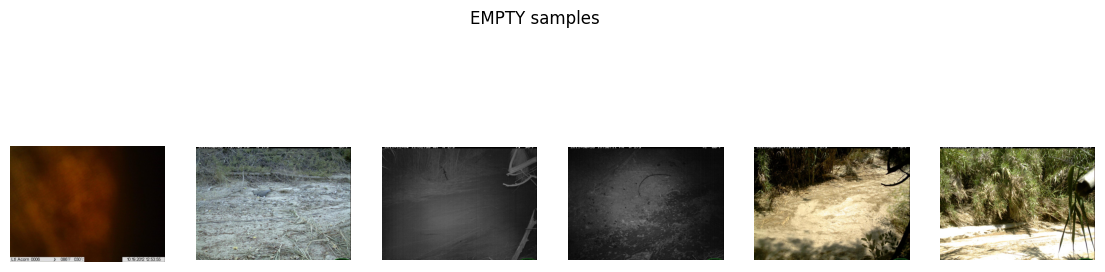

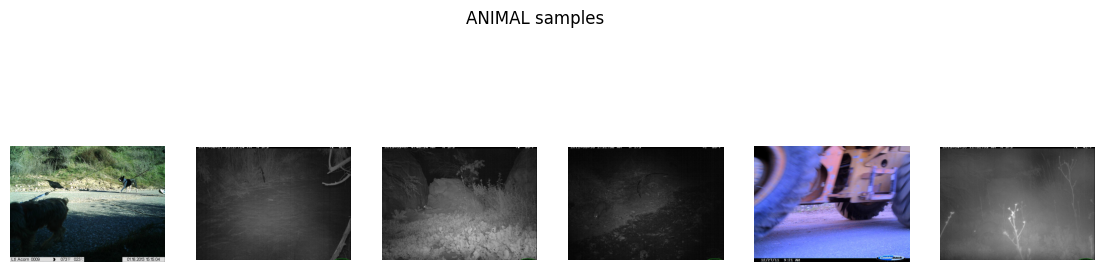

In [12]:
from PIL import Image
import matplotlib.pyplot as plt

def show_samples(df_in, title, n=6):
    samp = df_in.sample(n=min(n, len(df_in)), random_state=42)
    plt.figure(figsize=(14,4))
    for i, p in enumerate(samp["path"].tolist(), 1):
        img = Image.open(p).convert("RGB")
        plt.subplot(1, len(samp), i)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

show_samples(df[df["is_empty"]==1], "EMPTY samples", n=6)
show_samples(animals, "ANIMAL samples", n=6)


In [13]:
# Create Stage 1 (empty/animal/car) image-level CSV
import pandas as pd
from collections import Counter

SRC = "/content/drive/MyDrive/datasets/cct20/processed/cct20_species_annotations.csv"
df = pd.read_csv(SRC)

# subset -> split
subset_to_split = {
    "train_annotations": "train",
    "cis_val_annotations": "val_cis",
    "trans_val_annotations": "val_trans",
    "cis_test_annotations": "test_cis",
    "trans_test_annotations": "test_trans",
}
df["split"] = df["subset"].map(subset_to_split).fillna("unknown")

# For Stage 1, label per image: empty / car / animal
# - if any annotation is empty -> empty (rare; but keep)
# - else if any annotation is car -> car
# - else -> animal
# (In your data, images typically are one label, but this is safe.)

def stage1_label(group):
    names = [str(x).lower() for x in group["category_name"].tolist()]
    if any("empty" in n or "blank" in n for n in names):
        return "empty"
    if any(n == "car" for n in names):
        return "car"
    return "animal"

img_stage1 = (
    df.groupby(["subset","image_id","path","split"], as_index=False)
      .apply(lambda g: pd.Series({"label_stage1": stage1_label(g)}))
      .reset_index(drop=True)
)

out1 = "/content/drive/MyDrive/datasets/cct20/processed/cct20_stage1_imagelevel.csv"
img_stage1.to_csv(out1, index=False)

print("Saved:", out1)
print("Rows:", len(img_stage1))
print("\nStage 1 label counts:\n", img_stage1["label_stage1"].value_counts())
print("\nSplit counts:\n", img_stage1["split"].value_counts())


/tmp/ipython-input-1738920357.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({"label_stage1": stage1_label(g)}))


Saved: /content/drive/MyDrive/datasets/cct20/processed/cct20_stage1_imagelevel.csv
Rows: 57864

Stage 1 label counts:
 label_stage1
animal    51237
empty      4014
car        2613
Name: count, dtype: int64

Split counts:
 split
test_trans    23275
test_cis      15827
train         13553
val_cis        3484
val_trans      1725
Name: count, dtype: int64


In [14]:
# Create Stage 2 (species: 11 + other) image-level CSV
import pandas as pd
from collections import Counter

SRC = "/content/drive/MyDrive/datasets/cct20/processed/cct20_species_annotations.csv"
df = pd.read_csv(SRC)

subset_to_split = {
    "train_annotations": "train",
    "cis_val_annotations": "val_cis",
    "trans_val_annotations": "val_trans",
    "cis_test_annotations": "test_cis",
    "trans_test_annotations": "test_trans",
}
df["split"] = df["subset"].map(subset_to_split).fillna("unknown")

# Stage 2 uses ONLY animal species (no empty, no car)
df2 = df[(df["is_empty"] == 0) & (df["category_name"].str.lower() != "car")].copy()

# pick 1 label per image: most common within the image (safe for multi-annot cases)
def pick_label(group):
    names = group["category_name"].tolist()
    return Counter(names).most_common(1)[0][0]

img_species = (
    df2.groupby(["subset","image_id","path","split"], as_index=False)
       .apply(lambda g: pd.Series({"label_name": pick_label(g)}))
       .reset_index(drop=True)
)

# Choose 11 species + other (based on your counts)
keep_species = [
    "opossum","raccoon","rabbit","coyote","bobcat","cat",
    "squirrel","dog","bird","skunk","rodent"
]

# normalize to lowercase for matching
img_species["label_lower"] = img_species["label_name"].str.lower()
img_species["label_stage2"] = img_species["label_lower"].where(img_species["label_lower"].isin(keep_species), "other")

out2 = "/content/drive/MyDrive/datasets/cct20/processed/cct20_stage2_species_imagelevel.csv"
img_species[["subset","image_id","path","split","label_stage2"]].to_csv(out2, index=False)

print("Saved:", out2)
print("Rows:", len(img_species))
print("\nStage 2 label counts:\n", img_species["label_stage2"].value_counts())
print("\nSplit counts:\n", img_species["split"].value_counts())


/tmp/ipython-input-690060162.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({"label_name": pick_label(g)}))


Saved: /content/drive/MyDrive/datasets/cct20/processed/cct20_stage2_species_imagelevel.csv
Rows: 51237

Stage 2 label counts:
 label_stage2
opossum     13688
raccoon      7841
rabbit       5549
coyote       5315
bobcat       4961
cat          4601
squirrel     3181
dog          2788
bird         1402
skunk         857
rodent        812
other         242
Name: count, dtype: int64

Split counts:
 split
test_trans    20384
test_cis      13856
train         12885
val_cis        2448
val_trans      1664
Name: count, dtype: int64


In [15]:
import pandas as pd, os

s1 = pd.read_csv("/content/drive/MyDrive/datasets/cct20/processed/cct20_stage1_imagelevel.csv")
s2 = pd.read_csv("/content/drive/MyDrive/datasets/cct20/processed/cct20_stage2_species_imagelevel.csv")

print("Stage1 missing paths:", (s1["path"].apply(os.path.exists) == False).sum())
print("Stage2 missing paths:", (s2["path"].apply(os.path.exists) == False).sum())
print("\nStage2 classes:", sorted(s2["label_stage2"].unique()))


Stage1 missing paths: 0
Stage2 missing paths: 0

Stage2 classes: ['bird', 'bobcat', 'cat', 'coyote', 'dog', 'opossum', 'other', 'rabbit', 'raccoon', 'rodent', 'skunk', 'squirrel']


✅ After this notebook, you should have in Drive processed/:

* cct20_species_annotations.csv
* cct20_stage1_imagelevel.csv
* cct20_stage2_species_imagelevel.csv